### Sales Department

Aim: Sales team provided data of 1115 stores. The objective is to predict daily Sales based on features (eg. stores promotions, school, state holidays, distance away from competition, products, etc).  

Inputs and expected output

First dataset
- ID: unique id
- Store: unique store id
- Customers: number of customers
- Open: Boolean for opening (0 = Closed, 1 = Open)
- Promo: if store running promo on the day or not
- StateHoliday: indicate whether state holiday (a = publicHoliday, b = easterHoliday, c = Christmas, 0 = None)
- SchoolHoliday: if (store, date) affected by closure of public schools 

Second dataset
- StoreType: categorical type indicative of type of store (a, b, c, d)
- Assortment: a = basic, b = extra, c = extended
- CompetitionDistance(meters): distance to closest c competitor store
- CompetitionOpenSince [Month/Year]: date when competition was open
- Promo2: wheter store in promotional program or not (bool)
- Promo2SinceWeek / Year: week and year since store started participating in promo prgram if applicable
- PromoInterval: intervals at which promo2 is offered. For example Jan, Apr, Jul, Oct suggests its offered in Jan, Apr, July, and Oct

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

##### Loading Data

Loading train data

In [2]:
sales_train_df = pd.read_csv("train.csv")
sales_train_df.sample(5)

/tmp/ipykernel_340811/2342981493.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  sales_train_df = pd.read_csv("train.csv")


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
100873,524,6,2015-05-02,11834,1612,1,0,0,0
788103,584,4,2013-07-25,3305,352,1,0,0,1
864128,789,6,2013-05-18,2513,337,1,0,0,0
232665,746,7,2015-01-04,0,0,0,0,0,1
292006,552,7,2014-11-02,0,0,0,0,0,0


In [3]:
sales_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


- 9 columns in total
-  8 features each contains 1,017,209 rows
- Target variable: Sales

In [4]:
sales_train_df.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


- On average, there were around 663 customers per store, with sales averaging around €5,774 per day.
- The number of customers and sales per day varied widely, as indicated by the high standard deviations.
- Stores were typically open 83% of the time and had promotions about 38% of the time.
- School holidays were less common, occurring only about 18% of the time.
- The minimum sales value is €0, indicating days when no sales were recorded.
- The maximum sales value is €41,551, indicating very high sales on certain days.
- The majority of days (75%) had sales below €7,856.

In [5]:
# Lets investigate the max sales day
sales_train_df.loc[sales_train_df["Sales"] == 41551]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
44393,909,1,2015-06-22,41551,1721,1,0,0,0


- Surprisingly we don't see any promo, state holiday or school holiday. 
- However it was 22nd June 2015. It could have been a good weather day, or there was a large nearby event to store 909. 
- Day of the week 1 could indicate it was either a Sunday or Monday.

In [6]:
# Lets investigate the max sales day
sales_train_df.loc[sales_train_df["Customers"] == 7388]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
993496,817,2,2013-01-22,27190,7388,1,1,0,0


- The day they had the most customers, 22nd Jan 2013, less sales were made than 22nd June 2015.
- This is because it was a promo day. More people came, however they bought products at major discounts, lowering the rate of revenue.

Loading store data

In [7]:
store_info_df = pd.read_csv("store.csv")
store_info_df.sample(5)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
975,976,a,a,4180.0,NaN,NaN,0,NaN,NaN,NaN
768,769,b,b,840.0,NaN,NaN,1,48.0,2012.0,"Jan,Apr,Jul,Oct"
249,250,d,a,3520.0,NaN,NaN,1,18.0,2012.0,"Feb,May,Aug,Nov"
316,317,d,a,3140.0,7.0,2013.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
728,729,c,c,8980.0,6.0,2011.0,0,NaN,NaN,NaN


In [8]:
store_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [9]:
store_info_df.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


- Competition distance on average is 5.4 km. Competitors are located at considerable distances from stores
- Around 51% of stores are part of promotional program and have been apart of the programme for an average of 23 weeks.
- All stores have been a part of the promotional program, with the youngest at 1 week.

In [10]:
store_info_df["CompetitionOpenSinceYear"].mode()

0    2013.0
Name: CompetitionOpenSinceYear, dtype: float64

Most competition has been open fairly recently since 2013

In [11]:
store_info_df["Promo2SinceYear"].mode()

0    2011.0
Name: Promo2SinceYear, dtype: float64

Most promotional programmes started in 2011

#### Exploratory Data Analysis

sales train df

<Axes: >

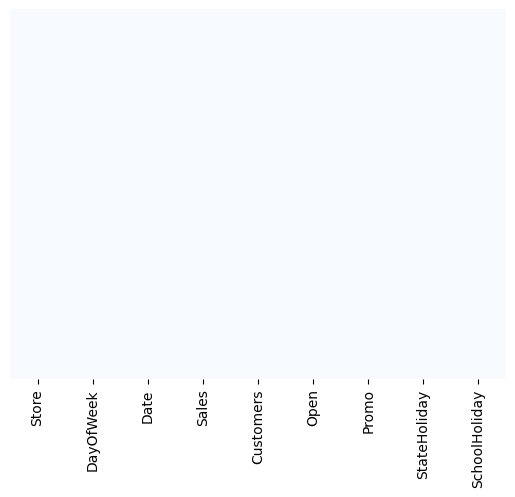

In [12]:
# See if there is any missing data in our 1 million rows.
sns.heatmap(sales_train_df.isnull(), yticklabels=False, cbar=False, cmap="Blues")

Luckily we don't see any null elements

array([[<Axes: title={'center': 'Store'}>,
        <Axes: title={'center': 'DayOfWeek'}>,
        <Axes: title={'center': 'Sales'}>],
       [<Axes: title={'center': 'Customers'}>,
        <Axes: title={'center': 'Open'}>,
        <Axes: title={'center': 'Promo'}>],
       [<Axes: title={'center': 'SchoolHoliday'}>, <Axes: >, <Axes: >]],
      dtype=object)

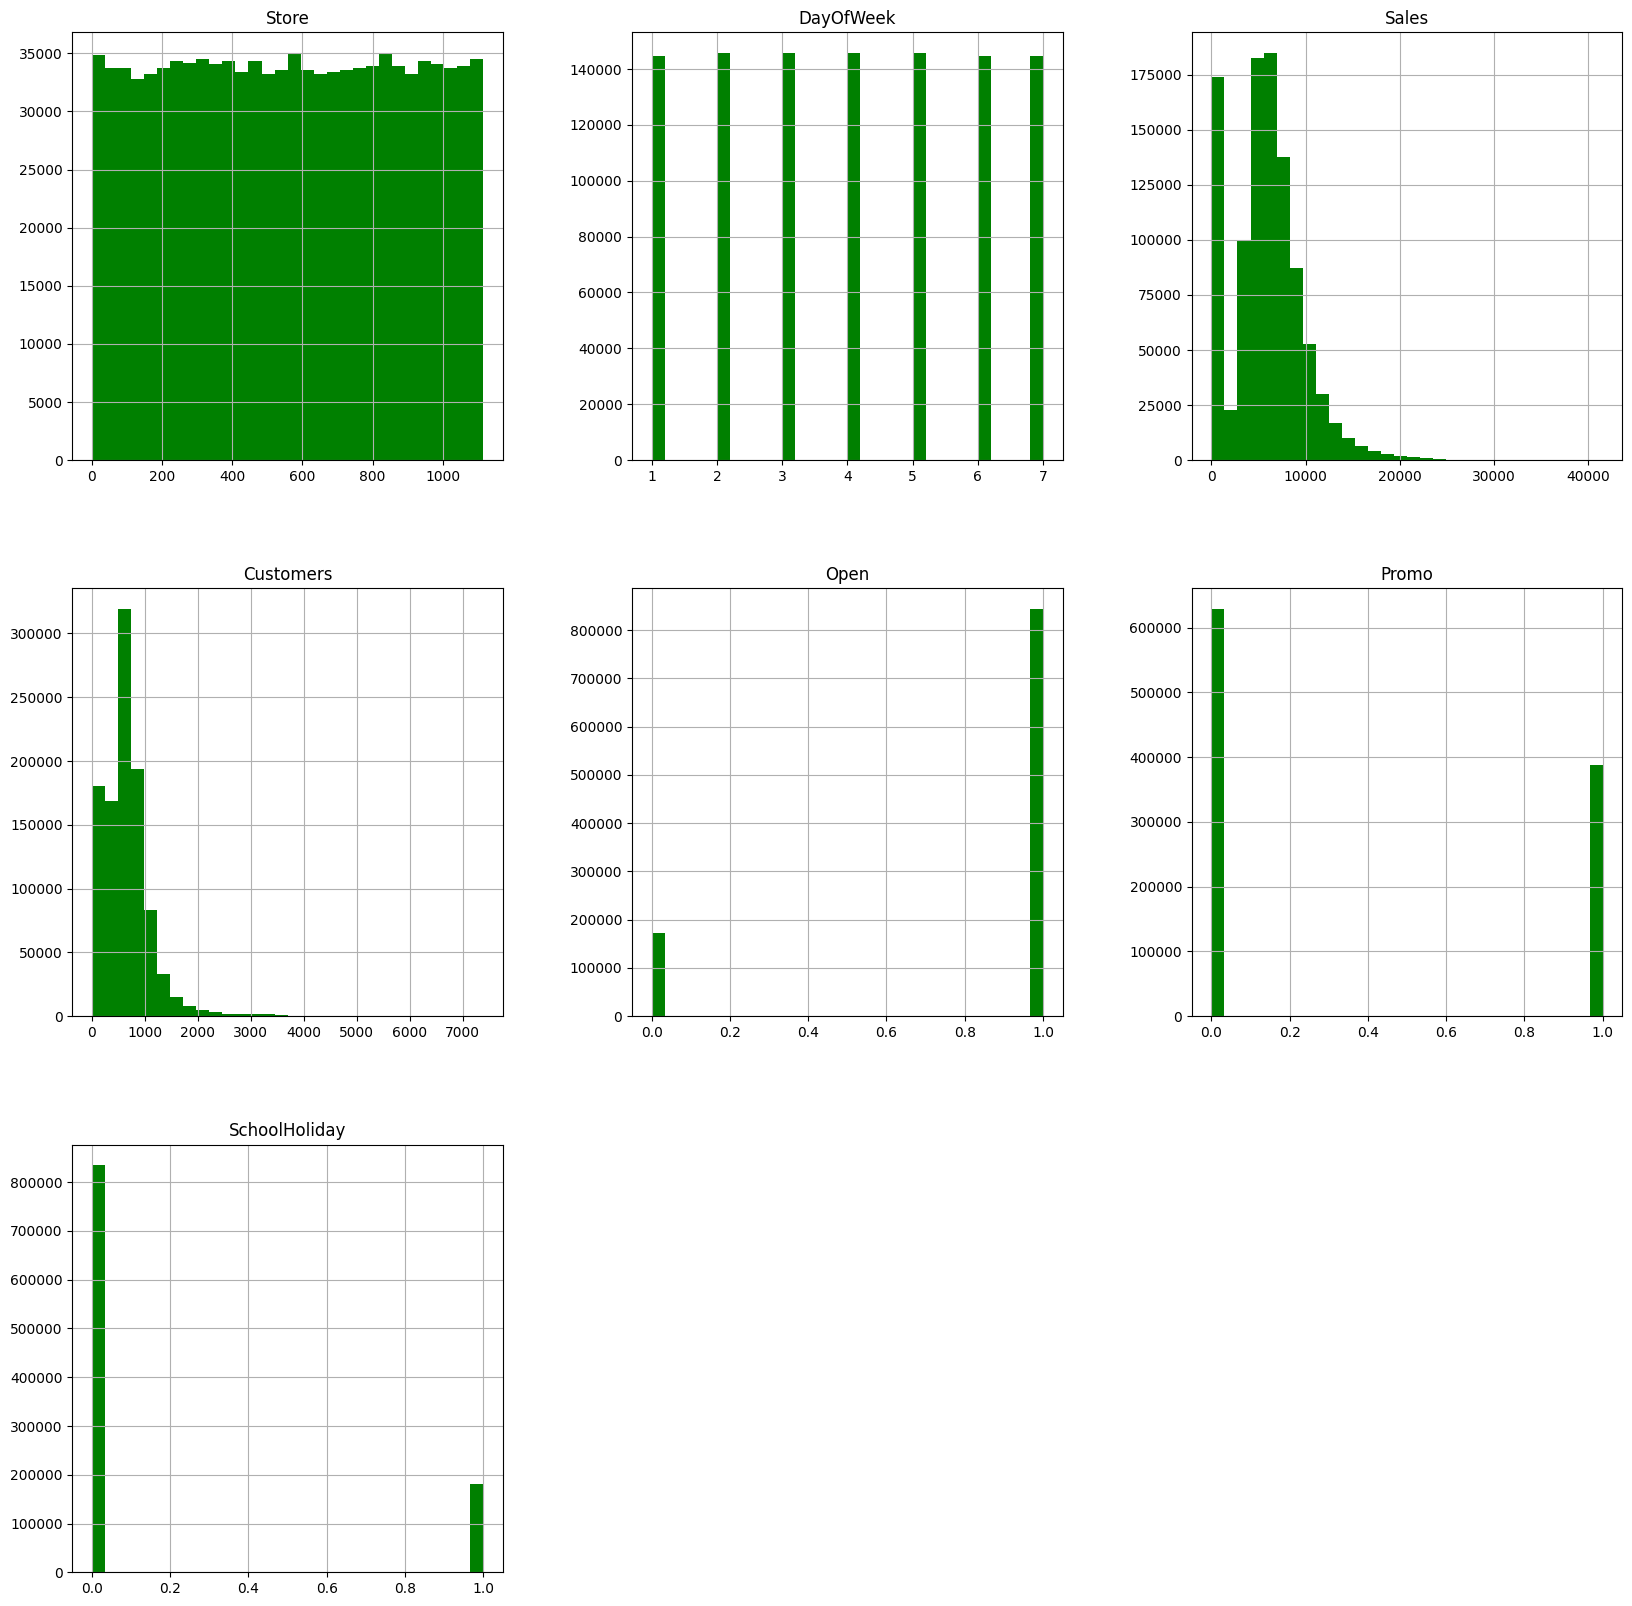

In [13]:
sales_train_df.hist(bins=30, figsize=(20, 20), color="g")

- Average of 600 customers per day with max around 4000. Note significant outlier at 7000. 
- Across days of week equally distributed - it is well represented with no bias
- Average sales around 5000 - 6000 euros
- Promo was around 40% of days, open 80% of days, school holidays 18% of days

In [14]:
closed_train_df = sales_train_df[sales_train_df["Open"] == 0]
open_train_df = sales_train_df[sales_train_df["Open"] == 1]

print("Total", len(sales_train_df))
print("Total closed store days:", len(closed_train_df))
print("Total open store days:", len(open_train_df))

Total 1017209
Total closed store days: 172817
Total open store days: 844392


In [15]:
# only keep open stores and remove closed stores for focus on insight during operation
sales_train_df = open_train_df
sales_train_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,3375,566,1,0,a,1
1016827,733,2,2013-01-01,10765,2377,1,0,a,1
1016863,769,2,2013-01-01,5035,1248,1,0,a,1
1017042,948,2,2013-01-01,4491,1039,1,0,a,1


In [16]:
# Lets drop open column since it has no meaning now
sales_train_df.drop(["Open"], axis=1, inplace=True)
sales_train_df.sample(3)

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday
124482,718,6,2015-04-11,6295,668,0,0,0
515170,826,4,2014-03-27,8129,801,0,0,0
372555,725,5,2014-08-08,5418,576,1,0,1


In [17]:
sales_train_df.describe()

,Store,DayOfWeek,Sales,Customers,Promo,SchoolHoliday
count,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000
mean,558.422920,3.520361,6955.514291,762.728395,0.446352,0.193580
std,321.731914,1.723689,3104.214680,401.227674,0.497114,0.395103
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,280.000000,2.000000,4859.000000,519.000000,0.000000,0.000000
50%,558.000000,3.000000,6369.000000,676.000000,0.000000,0.000000
75%,837.000000,5.000000,8360.000000,893.000000,1.000000,0.000000
max,1115.000000,7.000000,41551.000000,7388.000000,1.000000,1.000000


- Average sales went up to 6955 euros
- Average number of customers also went up to 762

store info df

<Axes: >

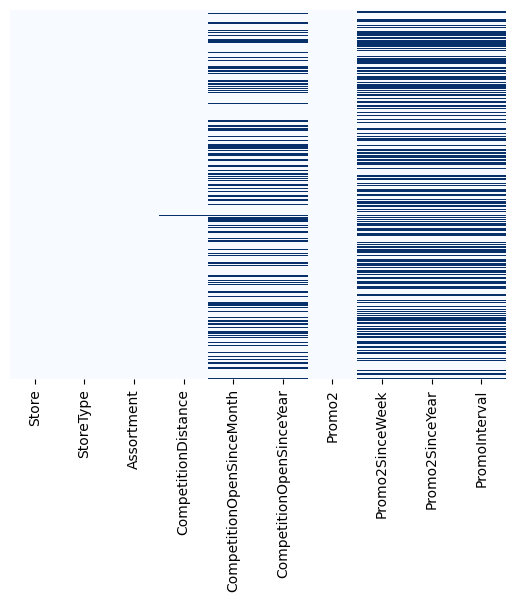

In [18]:
# See if any missing data in information dataframe
sns.heatmap(store_info_df.isnull(), yticklabels=False, cbar=False, cmap="Blues")

Most of the missing data is for competition related and Promo related variables. 
- Competition distance has a small amount of missing nulls.
- CompetitionOpenSinceMonth, CompetitionOpenSinceYear share a lot of nulls at same rows
- Promo2SinceWeek, Prommo2SinceYear, PromoInterval share a lot of nulls at same rows

In [19]:
store_info_df[store_info_df["CompetitionDistance"].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


Only three rows are missing for competition distance

In [20]:
store_info_df[store_info_df["CompetitionOpenSinceMonth"].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3270.0,NaN,NaN,0,NaN,NaN,NaN
18,19,a,c,3240.0,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
...,...,...,...,...,...,...,...,...,...,...
1095,1096,a,c,1130.0,NaN,NaN,1,10.0,2014.0,"Mar,Jun,Sept,Dec"
1099,1100,a,a,540.0,NaN,NaN,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


354 rows are missing for  CompetitionOpenSinceMonth

In [21]:
store_info_df[store_info_df["Promo2"] == 0]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
5,6,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN
6,7,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1107,1108,a,a,540.0,4.0,2004.0,0,NaN,NaN,NaN
1109,1110,c,c,900.0,9.0,2010.0,0,NaN,NaN,NaN
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN


We see all the rows are set to null when promo 2 is equal to zero

In [22]:
str_cols = [
    "Promo2SinceWeek",
    "Promo2SinceYear",
    "PromoInterval",
    "CompetitionOpenSinceYear",
    "CompetitionOpenSinceMonth",
]
for col in str_cols:
    store_info_df[col].fillna(0, inplace=True)

/tmp/ipykernel_340811/156104761.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  store_info_df[col].fillna(0, inplace=True)


<Axes: >

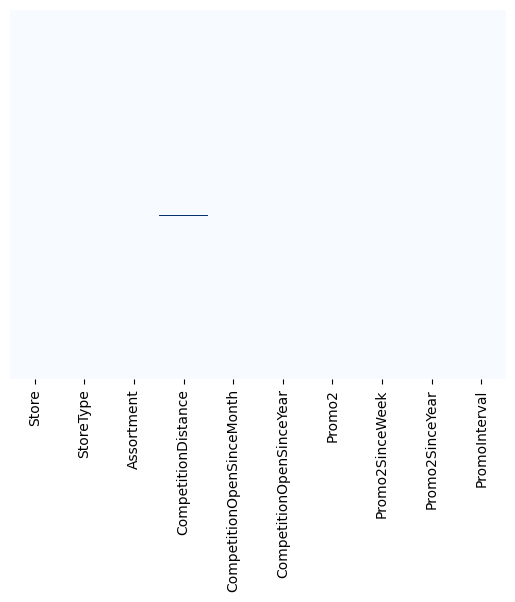

In [23]:
# Now we rid of all the missing values in the columns, only 3 rows remain from CompetitionDistance
sns.heatmap(store_info_df.isnull(), yticklabels=False, cbar=False, cmap="Blues")

In [24]:
store_info_df["CompetitionDistance"].fillna(
    store_info_df["CompetitionDistance"].mean(), inplace=True
)

/tmp/ipykernel_340811/266640925.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  store_info_df["CompetitionDistance"].fillna(


<Axes: >

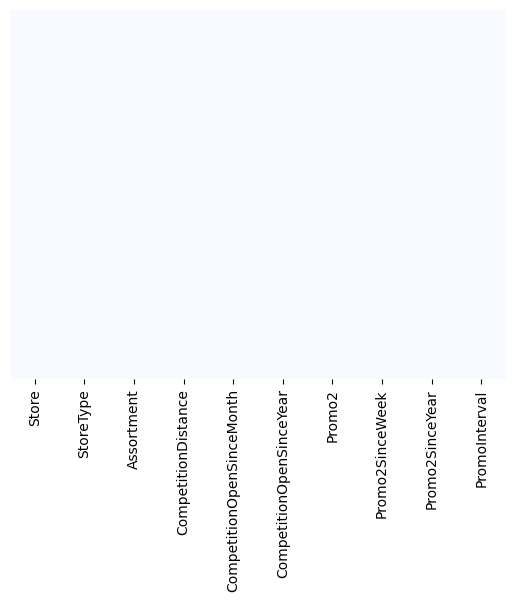

In [25]:
# Now we rid of the three rows CompetitionDistance
sns.heatmap(store_info_df.isnull(), yticklabels=False, cbar=False, cmap="Blues")

array([[<Axes: title={'center': 'Store'}>,
        <Axes: title={'center': 'CompetitionDistance'}>,
        <Axes: title={'center': 'CompetitionOpenSinceMonth'}>],
       [<Axes: title={'center': 'CompetitionOpenSinceYear'}>,
        <Axes: title={'center': 'Promo2'}>,
        <Axes: title={'center': 'Promo2SinceWeek'}>],
       [<Axes: title={'center': 'Promo2SinceYear'}>, <Axes: >, <Axes: >]],
      dtype=object)

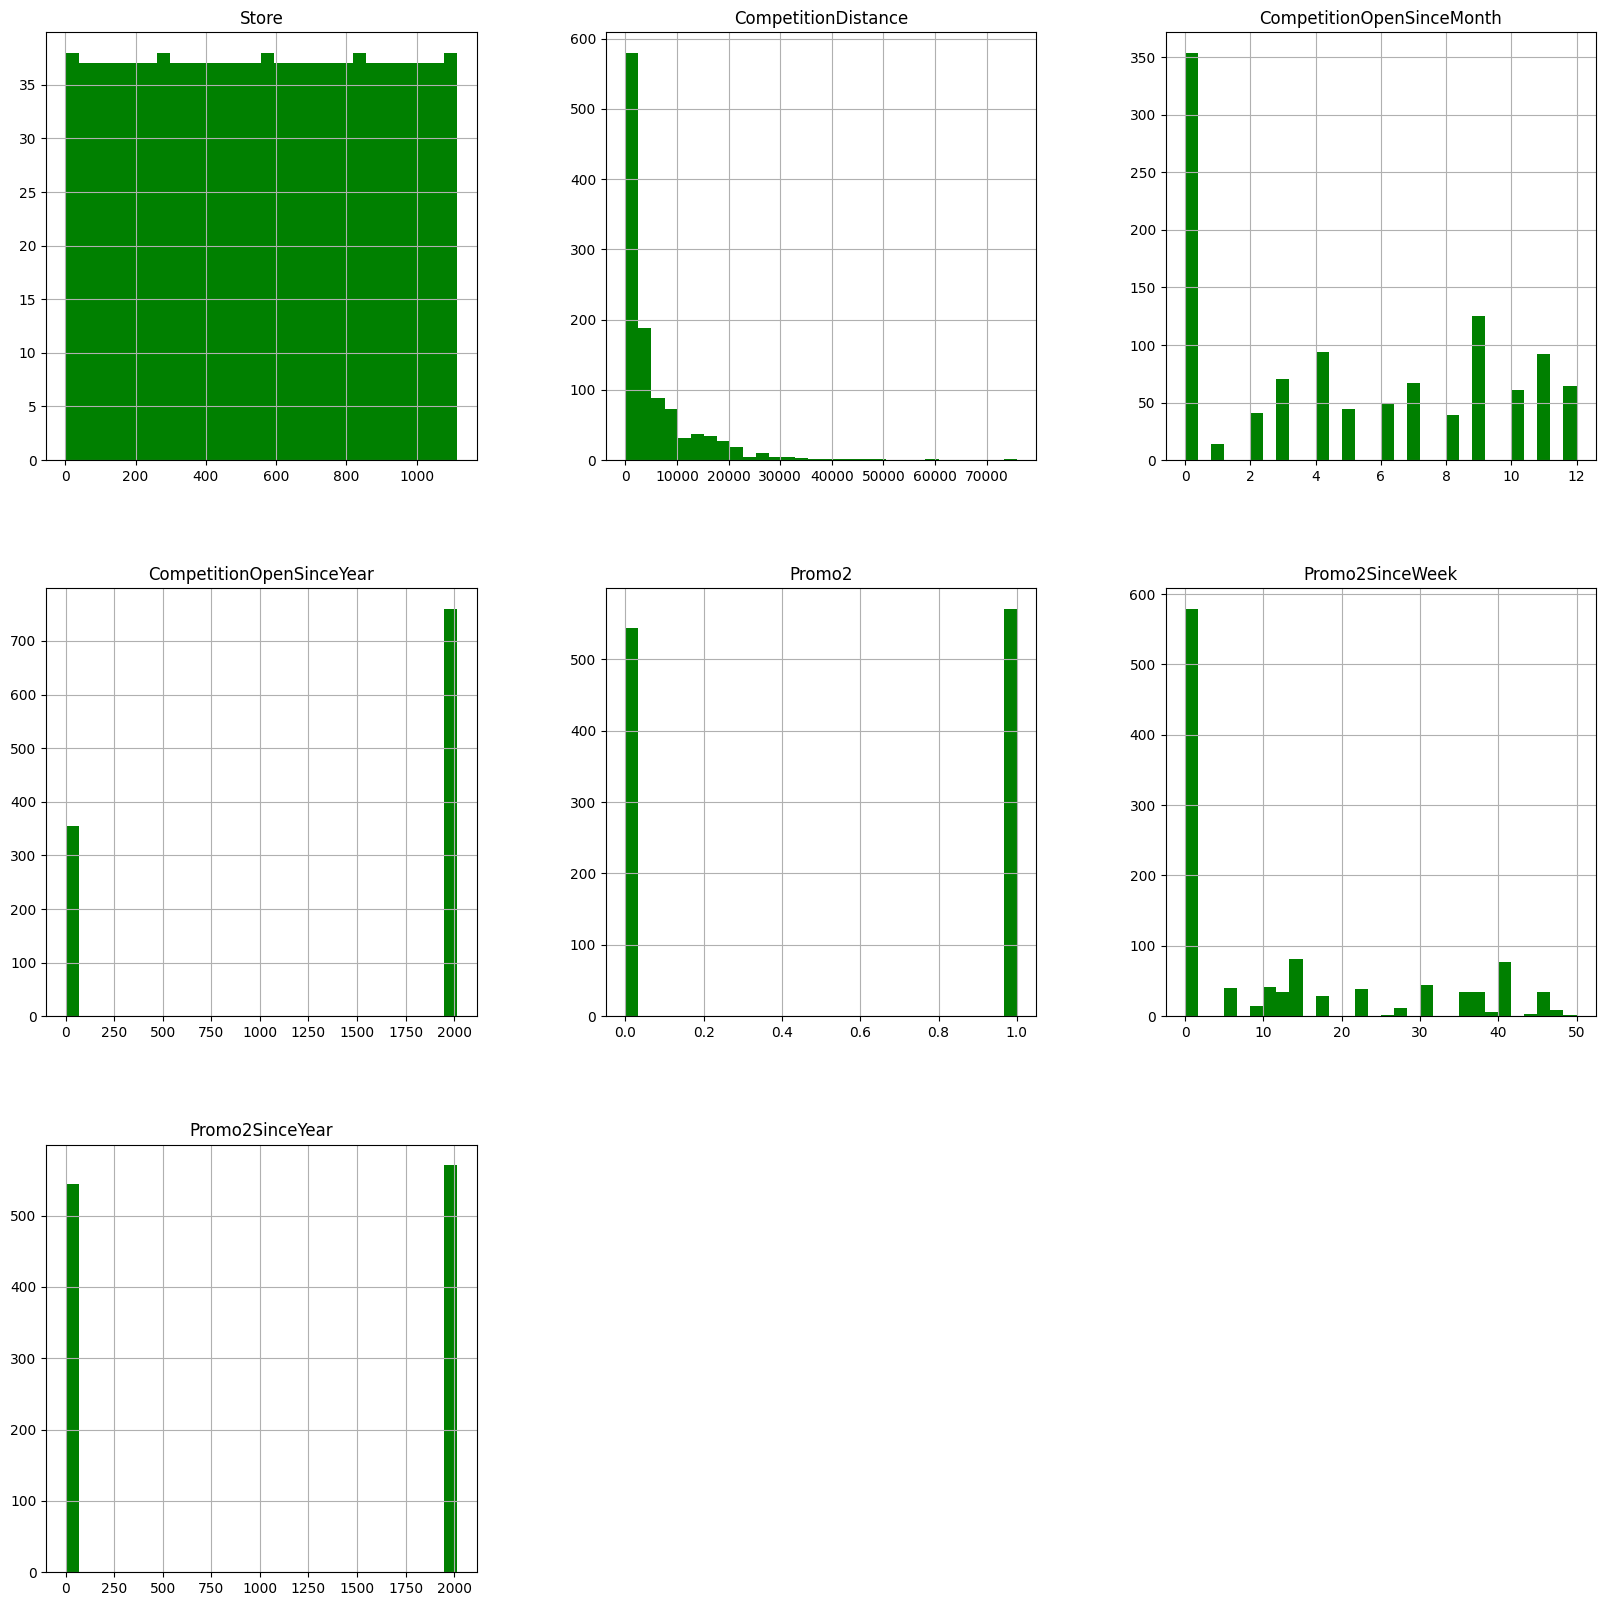

In [26]:
store_info_df.hist(bins=30, figsize=(20, 20), color="g")

##### Merging the dataset

In [27]:
sales_train_all_df = pd.merge(sales_train_df, store_info_df, how="inner", on="Store")
sales_train_all_df

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,5,2015-07-31,6064,625,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,0,1,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,5,2015-07-31,4822,559,1,0,1,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844387,682,2,2013-01-01,3375,566,0,a,1,b,a,150.0,9.0,2006.0,0,0.0,0.0,0
844388,733,2,2013-01-01,10765,2377,0,a,1,b,b,860.0,10.0,1999.0,0,0.0,0.0,0
844389,769,2,2013-01-01,5035,1248,0,a,1,b,b,840.0,0.0,0.0,1,48.0,2012.0,"Jan,Apr,Jul,Oct"
844390,948,2,2013-01-01,4491,1039,0,a,1,b,b,1430.0,0.0,0.0,0,0.0,0.0,0


In [28]:
sales_train_all_df_numeric = sales_train_all_df.select_dtypes(include="number")
correlations = sales_train_all_df_numeric.corr()["Sales"].sort_values()
correlations

DayOfWeek                   -0.178736
Promo2SinceYear             -0.127621
Promo2                      -0.127596
Promo2SinceWeek             -0.058476
CompetitionDistance         -0.036343
CompetitionOpenSinceMonth   -0.018370
CompetitionOpenSinceYear     0.005266
Store                        0.007710
SchoolHoliday                0.038617
Promo                        0.368145
Customers                    0.823597
Sales                        1.000000
Name: Sales, dtype: float64

<Axes: >

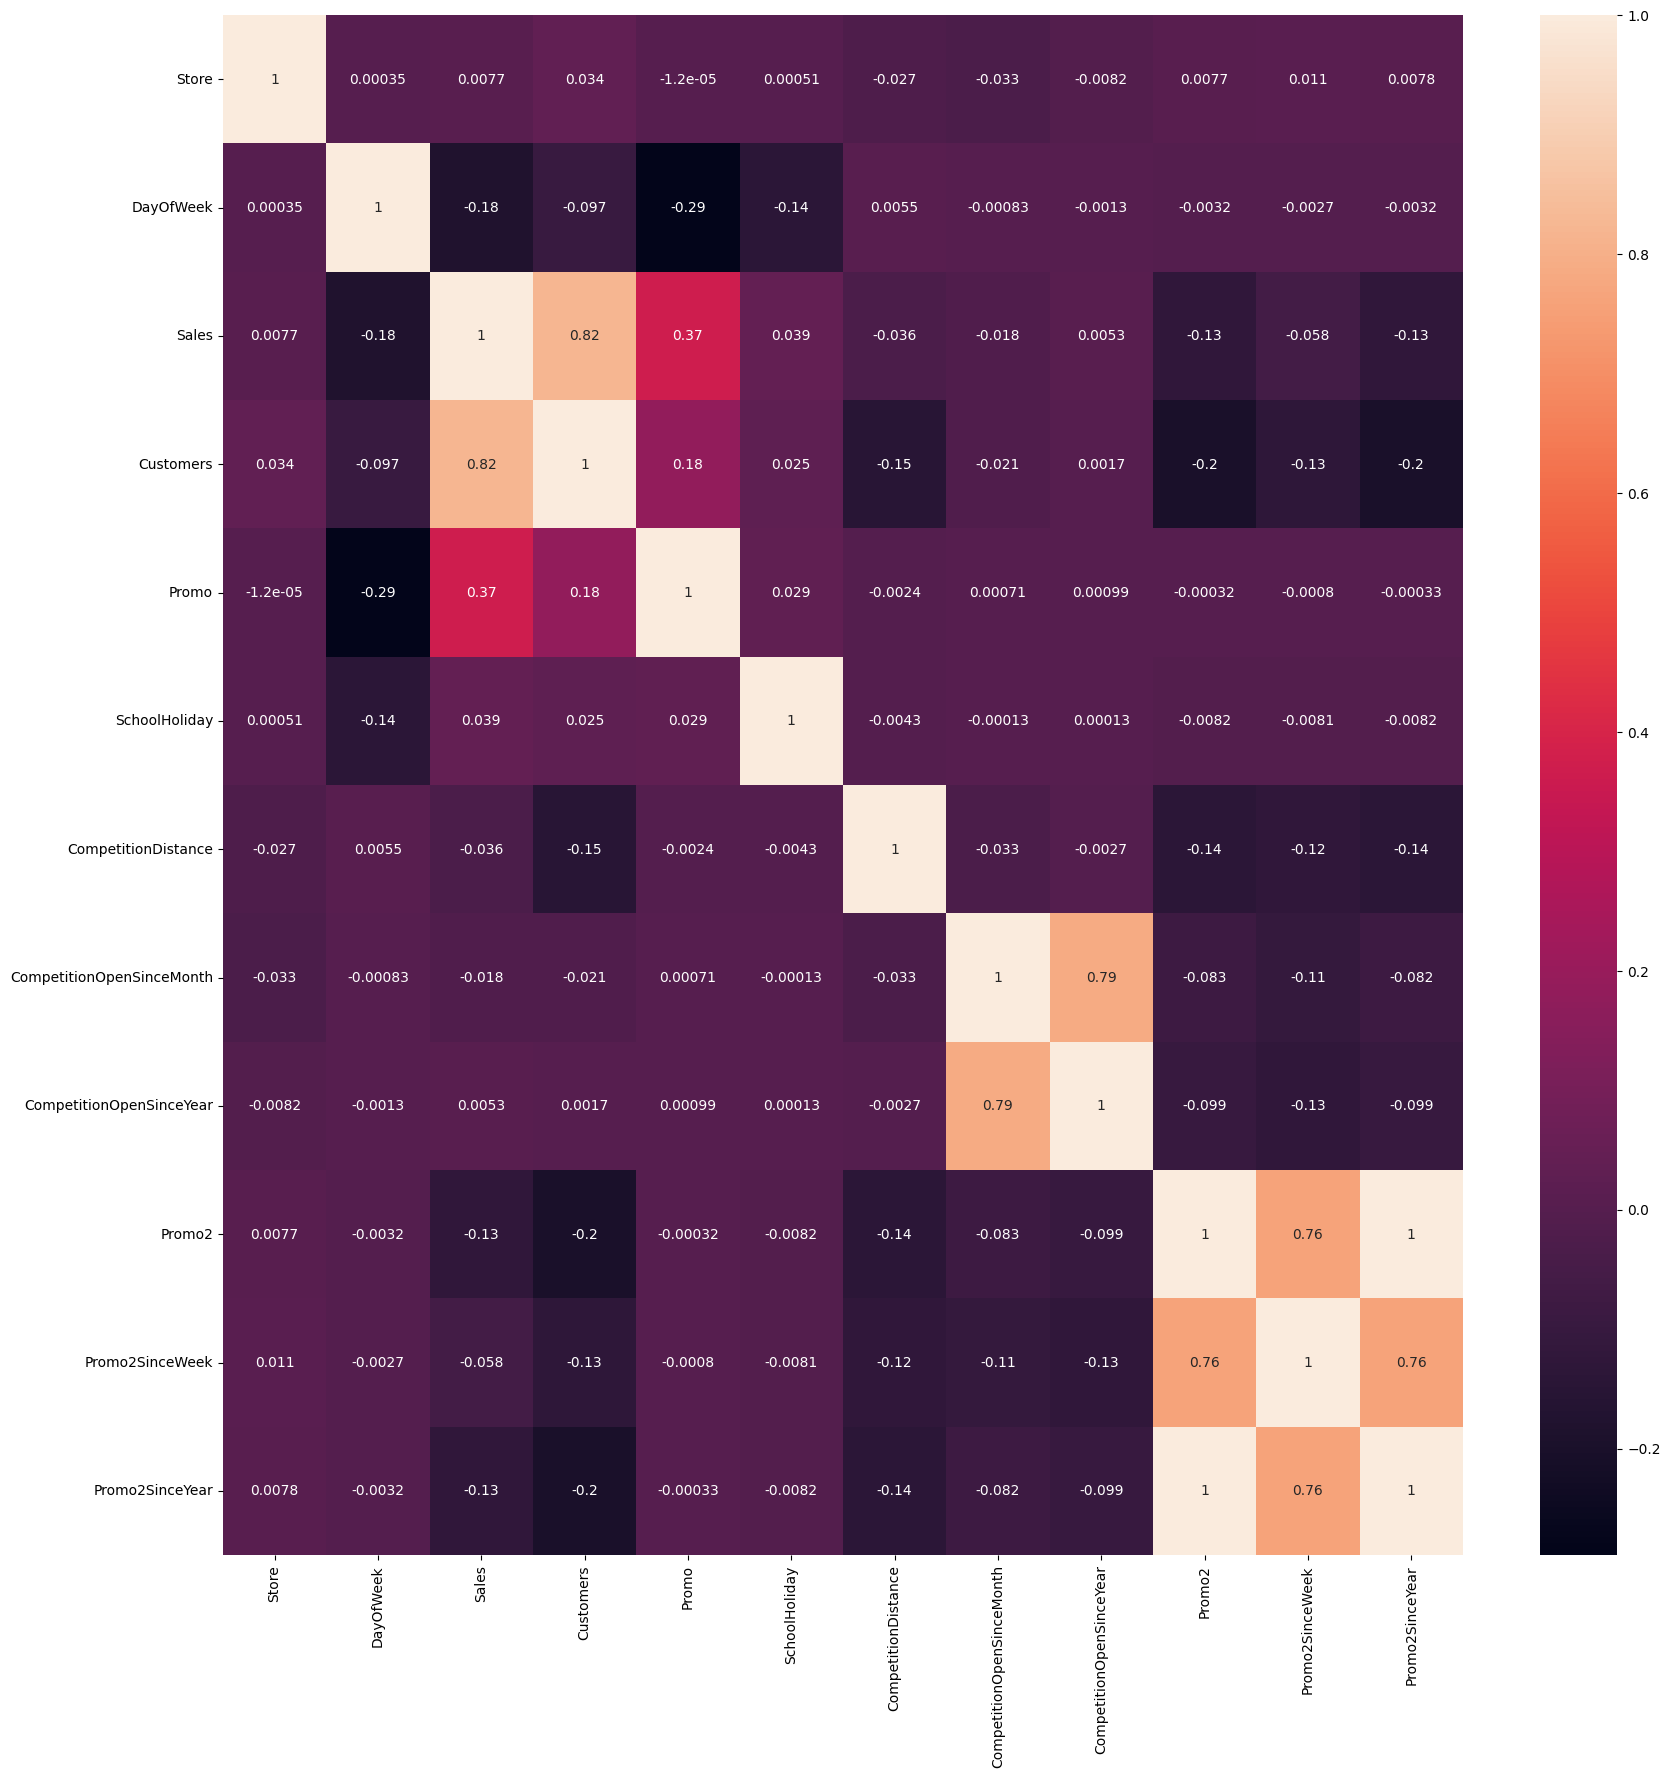

In [29]:
correlations = sales_train_all_df_numeric.corr()
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(correlations, annot=True)

- Promo2SinceYear and Promo2SinceWeek are considered only when Promo2 is 1, hence it is always 1 when Promo2 is 1.
- Strong correlation (0.82) between Customers and Sales.
- Weak correlation (0.37) between Promo and Sales. 

In [30]:
sales_train_all_df["Year"] = pd.DatetimeIndex(sales_train_all_df["Date"]).year
sales_train_all_df["Month"] = pd.DatetimeIndex(sales_train_all_df["Date"]).month
sales_train_all_df["Day"] = pd.DatetimeIndex(sales_train_all_df["Date"]).day
sales_train_all_df.sample(3)

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day
251446,785,2,2014-10-21,6627,495,1,0,0,d,c,970.0,7.0,2005.0,1,31.0,2013.0,"Feb,May,Aug,Nov",2014,10,21
182523,738,5,2015-01-16,9615,794,1,0,0,d,c,5980.0,10.0,2005.0,0,0.0,0.0,0,2015,1,16
238088,968,5,2014-11-07,8337,972,1,0,0,c,a,1190.0,0.0,0.0,0,0.0,0.0,0,2014,11,7


<Figure size 640x480 with 0 Axes>

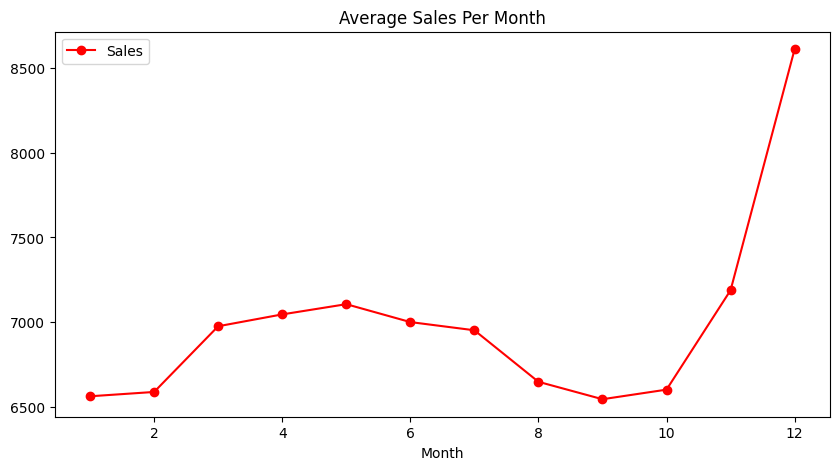

<Figure size 640x480 with 0 Axes>

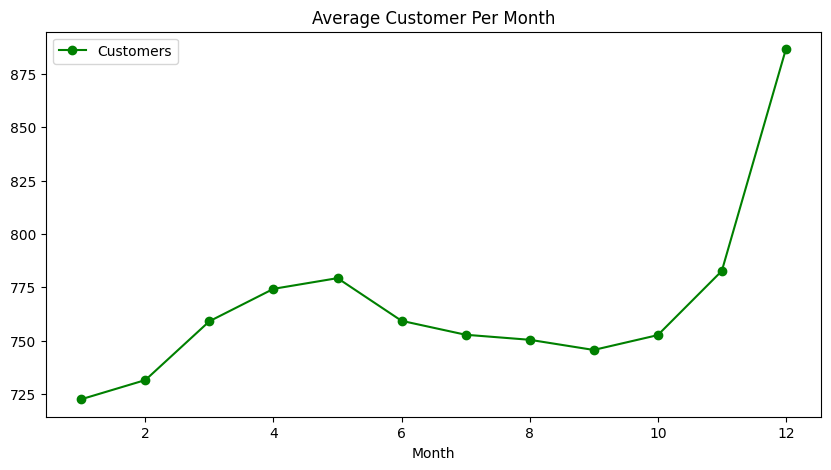

<Figure size 640x480 with 0 Axes>

In [31]:
axis = (
    sales_train_all_df.groupby("Month")[["Sales"]]
    .mean()
    .plot(figsize=(10, 5), marker="o", color="r")
)
axis.set_title("Average Sales Per Month")
plt.figure()

axis = (
    sales_train_all_df.groupby("Month")[["Customers"]]
    .mean()
    .plot(figsize=(10, 5), marker="o", color="g")
)
axis.set_title("Average Customer Per Month")
plt.figure()

- Sales peak around November and highest around Christmas shopping season
- Customer also reflects the Christmas time behaviour

<Figure size 640x480 with 0 Axes>

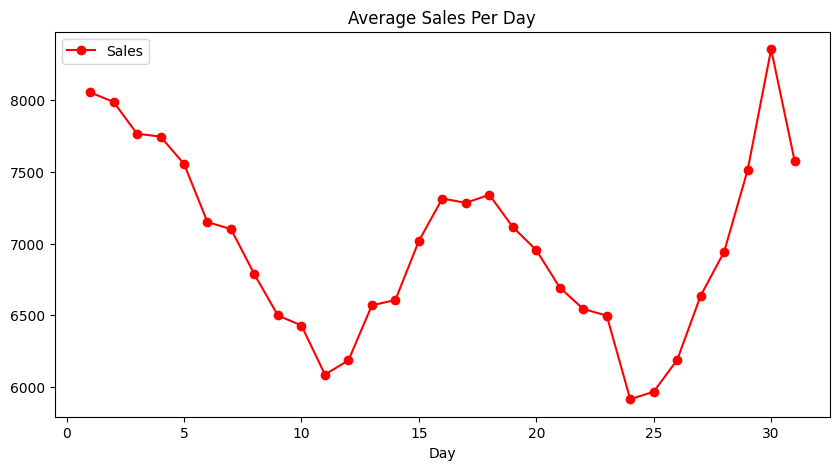

<Figure size 640x480 with 0 Axes>

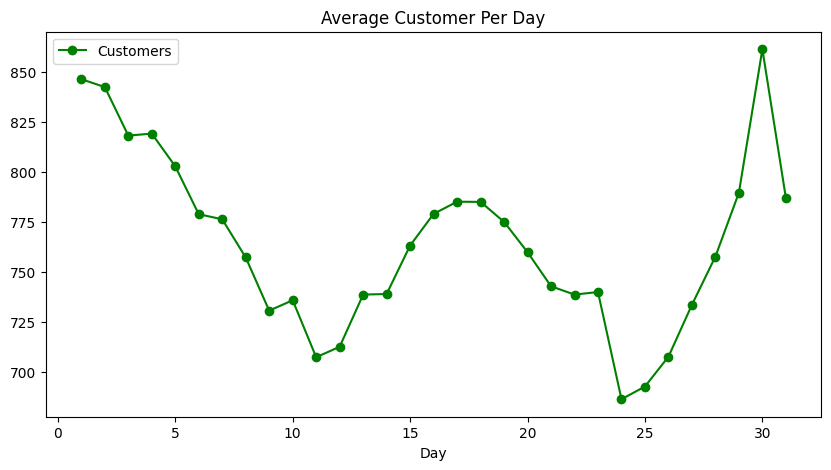

<Figure size 640x480 with 0 Axes>

In [32]:
axis = (
    sales_train_all_df.groupby("Day")[["Sales"]]
    .mean()
    .plot(figsize=(10, 5), marker="o", color="r")
)
axis.set_title("Average Sales Per Day")
plt.figure()

axis = (
    sales_train_all_df.groupby("Day")[["Customers"]]
    .mean()
    .plot(figsize=(10, 5), marker="o", color="g")
)
axis.set_title("Average Customer Per Day")
plt.figure()

- From days 15th-20th a small hump in customer activity occurs
- A peak happens on the last day of the month to first day of the next. This could relate to customer recieving their pay checks, and spending after their budgets refresh

<Figure size 640x480 with 0 Axes>

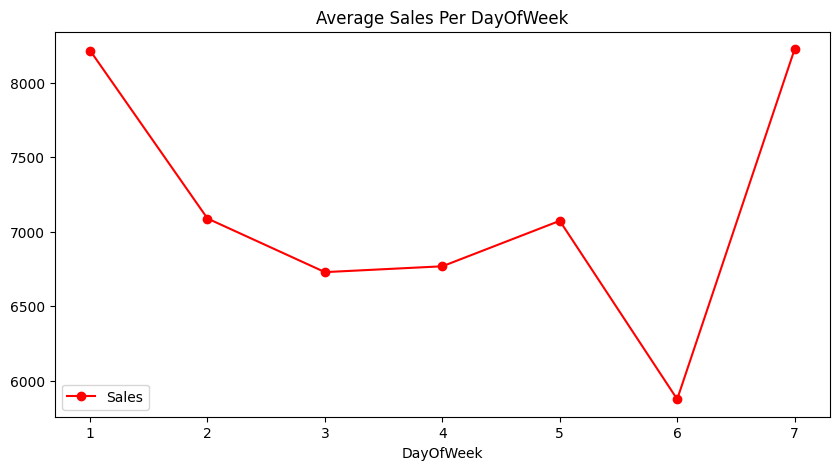

<Figure size 640x480 with 0 Axes>

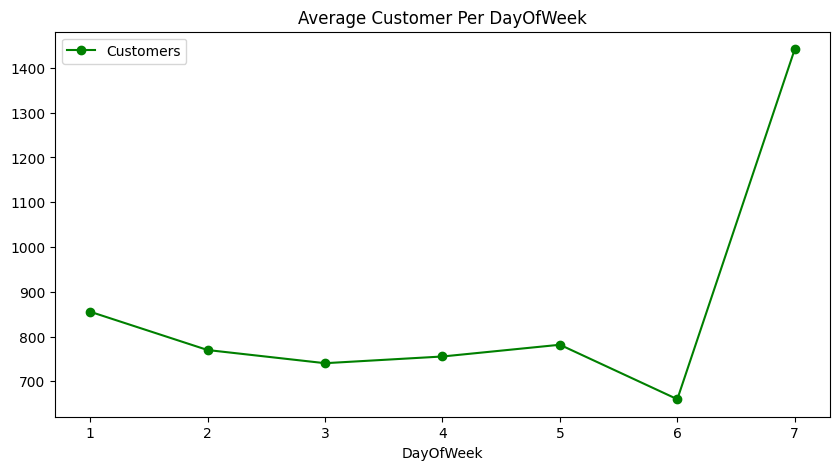

<Figure size 640x480 with 0 Axes>

In [33]:
axis = (
    sales_train_all_df.groupby("DayOfWeek")[["Sales"]]
    .mean()
    .plot(figsize=(10, 5), marker="o", color="r")
)
axis.set_title("Average Sales Per DayOfWeek")
plt.figure()

axis = (
    sales_train_all_df.groupby("DayOfWeek")[["Customers"]]
    .mean()
    .plot(figsize=(10, 5), marker="o", color="g")
)
axis.set_title("Average Customer Per DayOfWeek")
plt.figure()

Note that 7 is Sunday. Sales and Customers significantly peak on a Sunday.
- Customers on Sunday peak more than ~75% the usual
- Sales peaks on Sunday as well as Monday. at ~2000 euros more than Tuesday-Friday

Although we have much less customers on Monday, they spend a lot more than usual - matching the sales amount we see on Sunday with ~500 more customers. 

<Axes: xlabel='Date'>

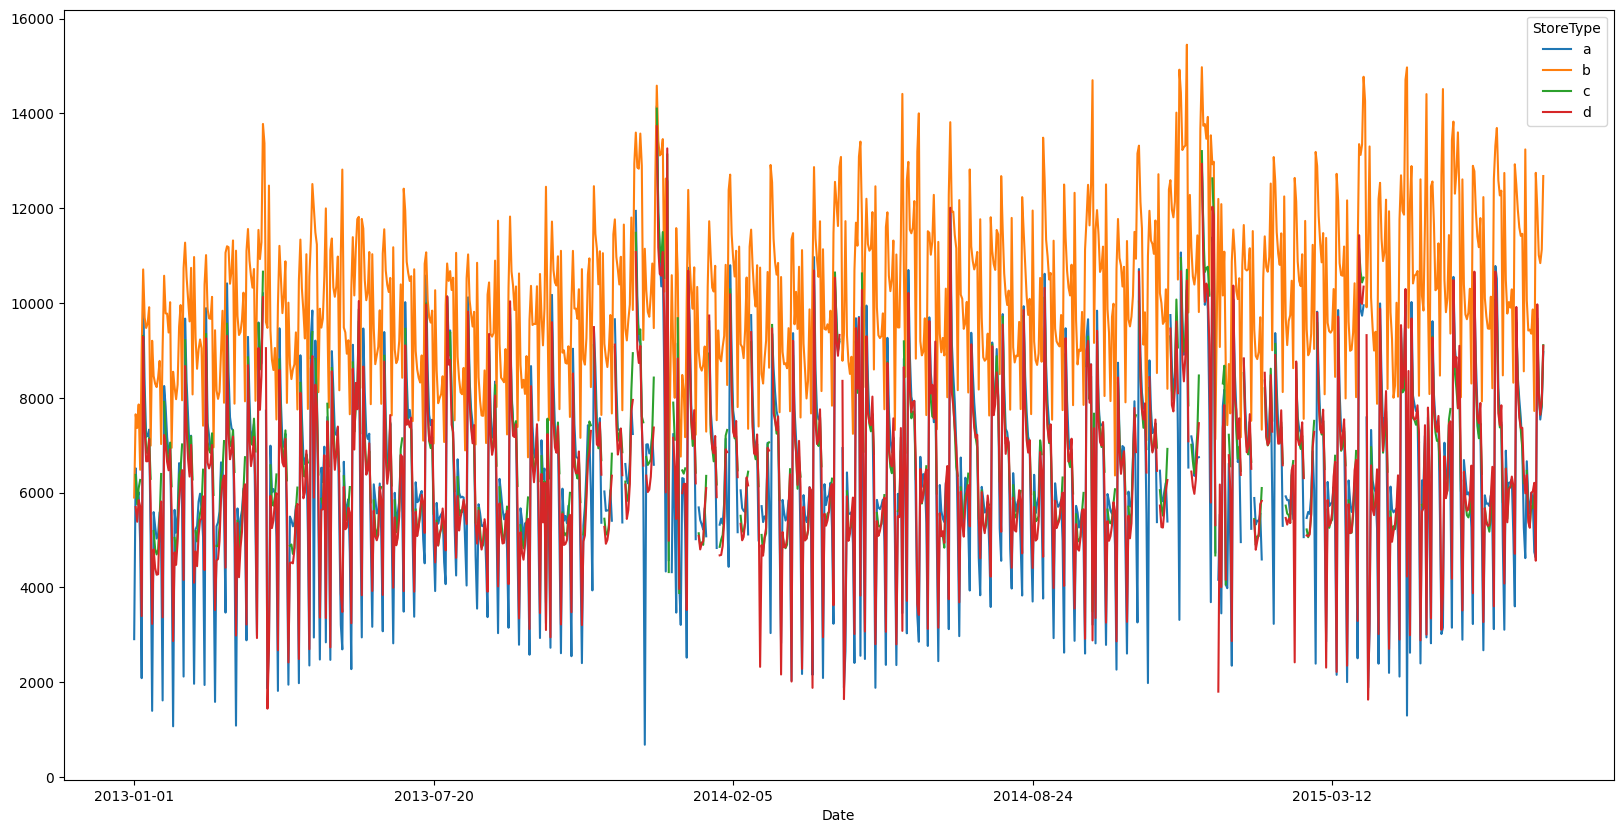

In [34]:
fig, ax = plt.subplots(figsize=(20, 10))
sales_train_all_df.groupby(["Date", "StoreType"])["Sales"].mean().unstack().plot(ax=ax)

We see that store type b makes the highest sales consistently throughout the years, whereas a has the lowest troughs.

<Axes: xlabel='Promo', ylabel='Customers'>

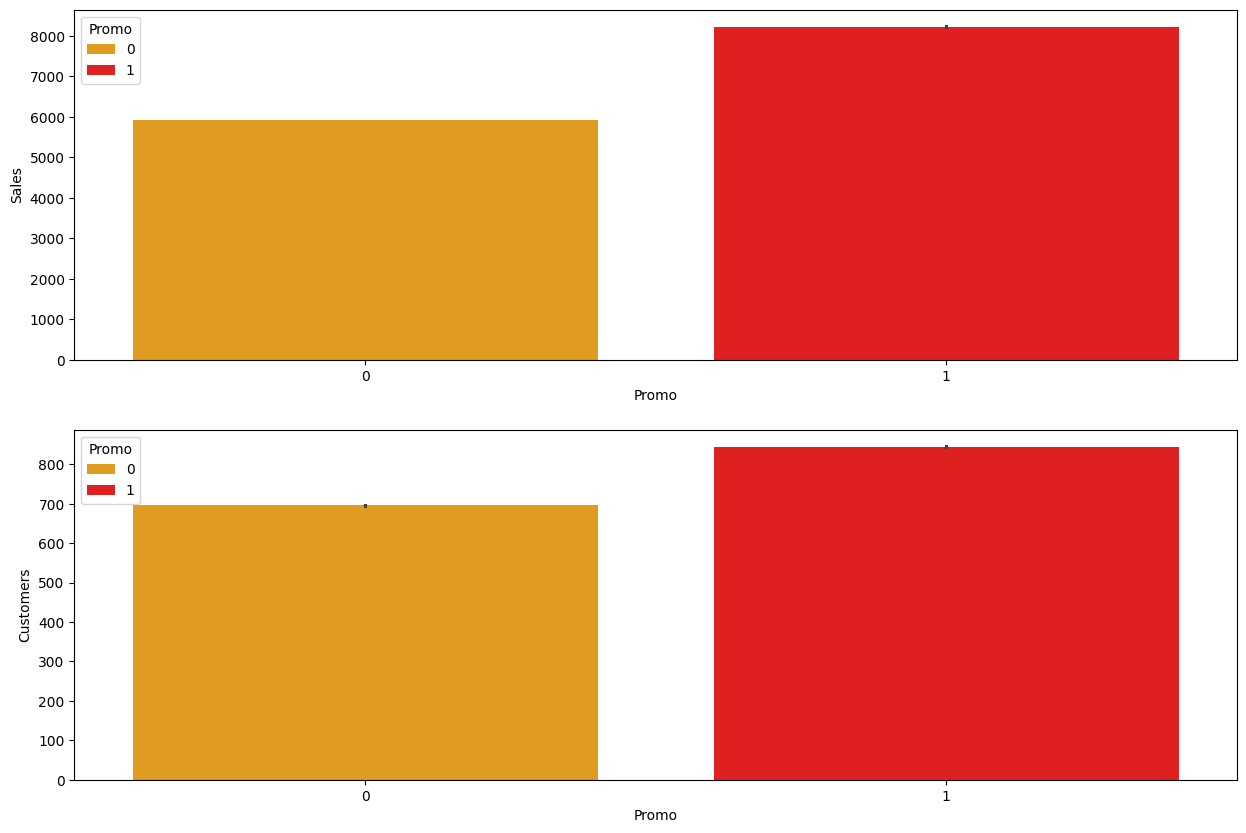

In [35]:
# Creating two subplots, each displaying a bar plot of "Sales" and "Customers" data from the sales_train_all_df.

plt.figure(figsize=(15, 10))

plt.subplot(211)
sns.barplot(
    x="Promo",
    y="Sales",
    data=sales_train_all_df,
    hue="Promo",
    palette={0: "orange", 1: "red"},
)

plt.subplot(212)
sns.barplot(
    x="Promo",
    y="Customers",
    data=sales_train_all_df,
    hue="Promo",
    palette={0: "orange", 1: "red"},
)

Promo is effective with a higher level of Sales as well as Customers.

<Axes: xlabel='Promo', ylabel='Customers'>

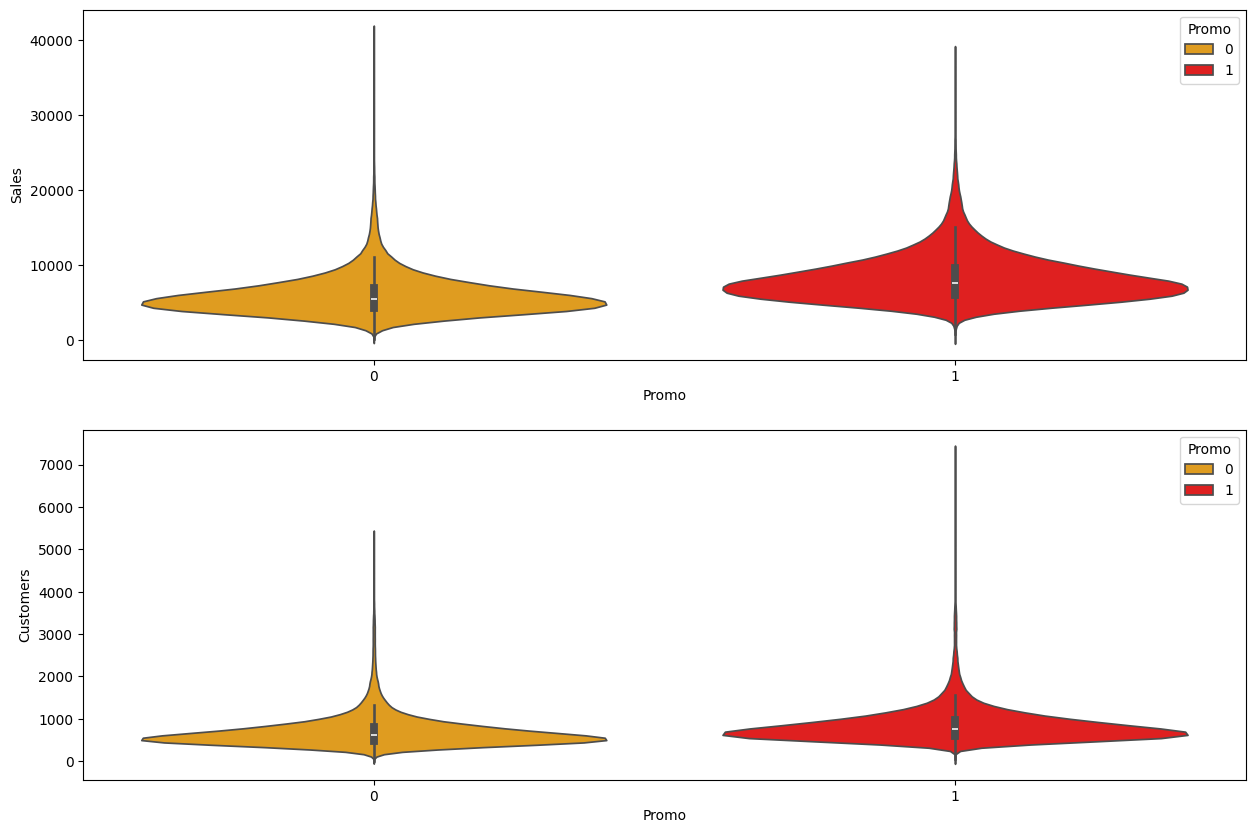

In [36]:
# Creating two subplots, each displaying a bar plot of "Sales" and "Customers" data from the sales_train_all_df.

plt.figure(figsize=(15, 10))

plt.subplot(211)
sns.violinplot(
    x="Promo",
    y="Sales",
    data=sales_train_all_df,
    hue="Promo",
    palette={0: "orange", 1: "red"},
)

plt.subplot(212)
sns.violinplot(
    x="Promo",
    y="Customers",
    data=sales_train_all_df,
    hue="Promo",
    palette={0: "orange", 1: "red"},
)

- Considering outliers there isn't much of a difference for Sales. Distribution is higher but not significantly with respect to outliers. The max is equivalent.
- We note a lot more customer outlyers with Promo however, ~2000 more customers than max of no promo.

#### Facebook Prophet

In [38]:
from prophet import Prophet

/home/russellsb/.cache/pypoetry/virtualenvs/data_science_for_business_package-muNh-jkR-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


17:35:53 - cmdstanpy - INFO - Chain [1] start processing
17:35:53 - cmdstanpy - INFO - Chain [1] done processing
/home/russellsb/.cache/pypoetry/virtualenvs/data_science_for_business_package-muNh-jkR-py3.10/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/russellsb/.cache/pypoetry/virtualenvs/data_science_for_business_package-muNh-jkR-py3.10/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
/home/russ

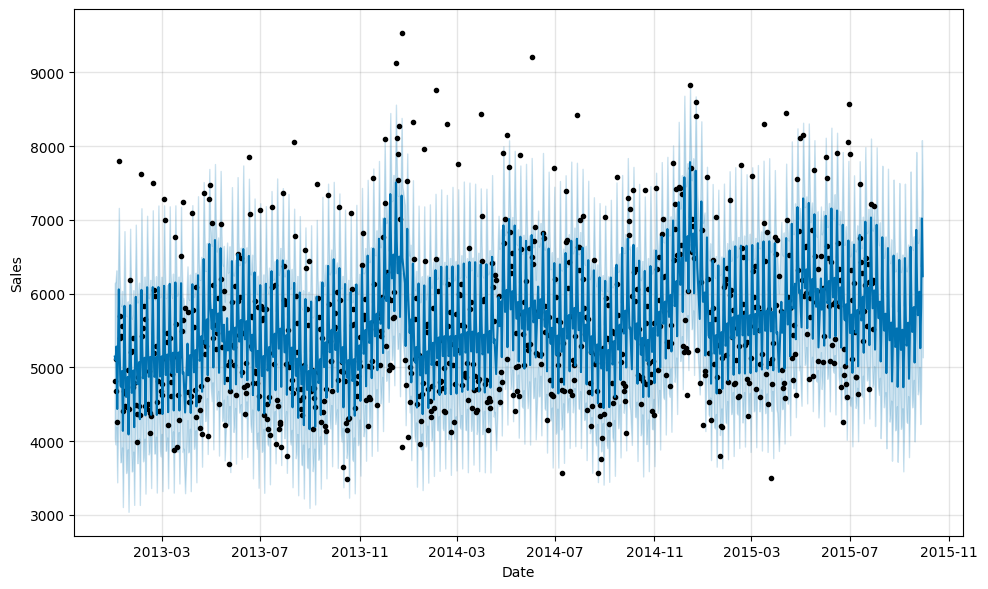

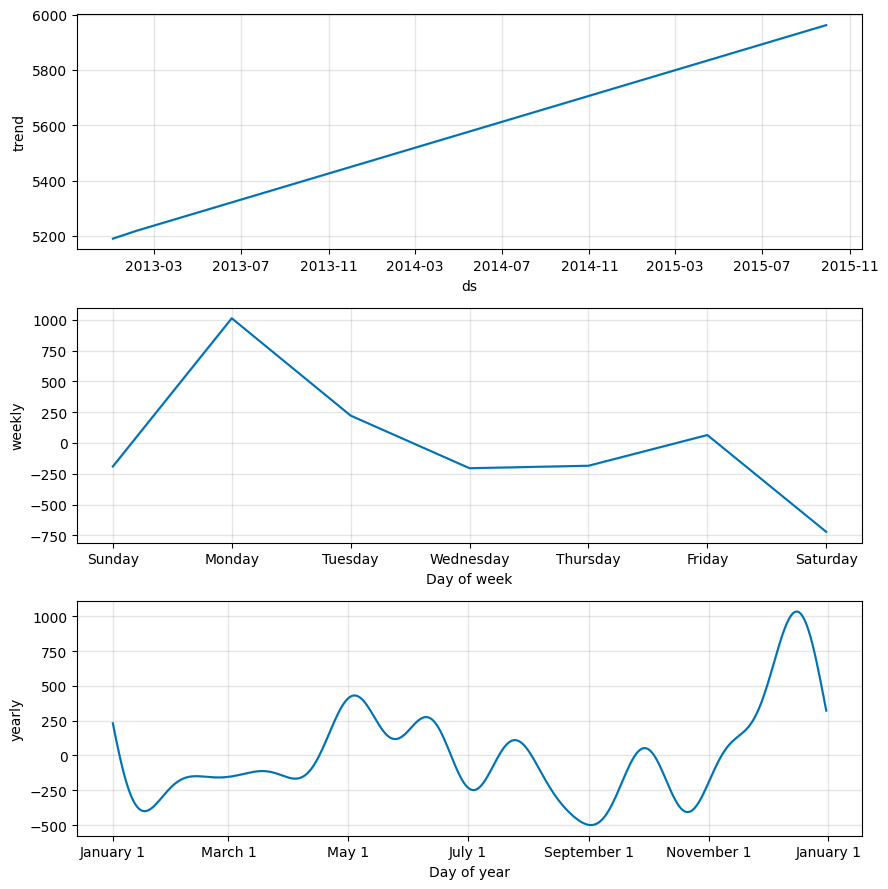

In [52]:
def sales_predictions(sales_df, store_id, periods):
    sales_df = sales_df[sales_df["Store"] == store_id]
    sales_df = sales_df[["Date", "Sales"]].rename(columns={"Date": "ds", "Sales": "y"})
    sales_df = sales_df.sort_values("ds")

    model = Prophet()
    model.fit(sales_df)
    future = model.make_future_dataframe(periods=periods)
    forecast = model.predict(future)

    figure = model.plot(forecast, xlabel="Date", ylabel="Sales")
    figure2 = model.plot_components(forecast)


sales_predictions(sales_train_all_df, store_id=10, periods=60)

18:15:39 - cmdstanpy - INFO - Chain [1] start processing
18:15:39 - cmdstanpy - INFO - Chain [1] done processing
/home/russellsb/.cache/pypoetry/virtualenvs/data_science_for_business_package-muNh-jkR-py3.10/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/russellsb/.cache/pypoetry/virtualenvs/data_science_for_business_package-muNh-jkR-py3.10/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
/home/russ

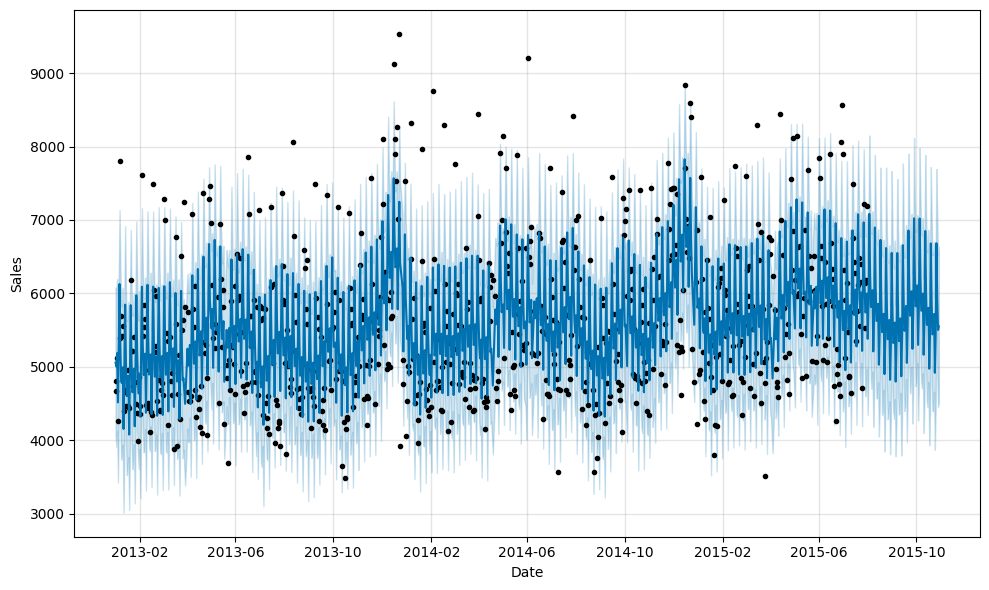

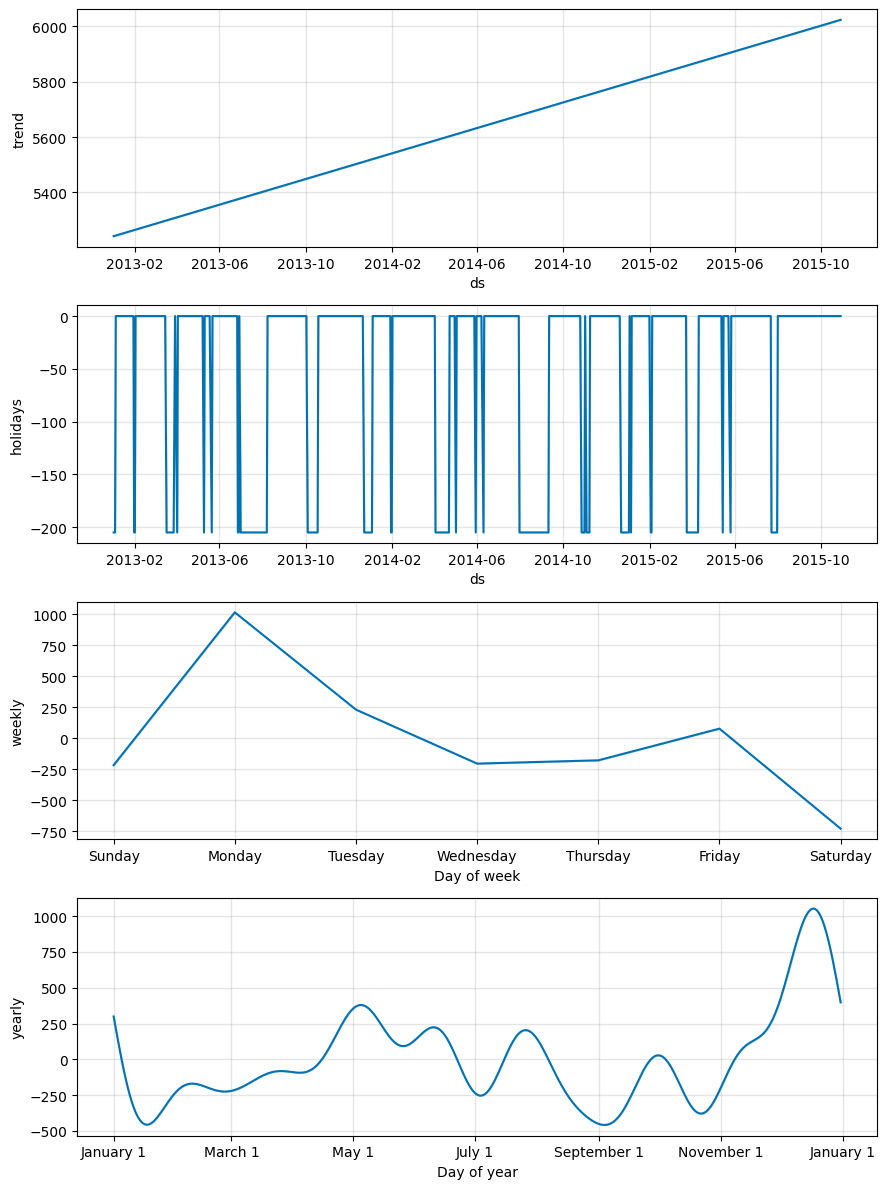

In [83]:
def sales_predictions(sales_df, store_id, periods):

    sales_df = sales_df[sales_df["Store"] == store_id]

    # Adding holidays
    school_holidays = sales_df[sales_df["SchoolHoliday"] == 1].loc[:, "Date"].values
    school_holidays = pd.DataFrame(
        {"ds": pd.to_datetime(school_holidays), "holiday": "school_holiday"}
    )

    state_holidays = (
        sales_df[
            (sales_df["StateHoliday"] == "a")
            | (sales_df["StateHoliday"] == "b")
            | (sales_df["StateHoliday"] == "c")
        ]
        .loc[:, "Date"]
        .values
    )
    state_holidays = pd.DataFrame(
        {"ds": pd.to_datetime(state_holidays), "holiday": "state_holiday"}
    )

    holidays = pd.concat([school_holidays, state_holidays])

    # Preparing main dataframe
    sales_df = sales_df[["Date", "Sales"]].rename(columns={"Date": "ds", "Sales": "y"})
    sales_df = sales_df.sort_values("ds")

    # Fitting into model and predicting
    model = Prophet(holidays=holidays)
    model.fit(sales_df)
    future = model.make_future_dataframe(periods=periods)
    forecast = model.predict(future)

    # Plotting results
    figure = model.plot(forecast, xlabel="Date", ylabel="Sales")
    figure2 = model.plot_components(forecast)


sales_predictions(sales_train_all_df, store_id=10, periods=90)